In [26]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


In [22]:
def read_MC(path, file_name, n_sipms, first_sipm, time_bin, event):
    os.chdir(path)
    tof_wave = np.array(pd.read_hdf(file_name,key='MC/tof_waveforms'), dtype='int')
    extents  = np.array(pd.read_hdf(file_name,key='MC/extents'), dtype='int')
    
    high_limit_tof = extents[event,2]
    if event == 0:
        low_limit_tof  = 0
    else:
        low_limit_tof  = extents[event-1,2]
    
    event_tof  = tof_wave[low_limit_tof:high_limit_tof+1,:]
    event_tof[:,0] = event_tof[:,0]*-1-first_sipm
    # SiPM  |  Timebin  |  Charge   
    
    conv_table = np.zeros((np.max(event_tof[:,1])+1,n_sipms))
    
    for i in range(event_tof.shape[0]):
        conv_table[event_tof[i,1],event_tof[i,0]] = event_tof[i,2]
        
    
    return conv_table
    

In [23]:
tof = read_MC("/mnt/715c6d30-57c4-4aed-a982-551291d8f848/NEUTRINOS/","full_ring_iradius165mm_z140mm_depth3cm_pitch7mm.000.pet.h5",3500,1000,5,0)

<Figure size 432x288 with 0 Axes>

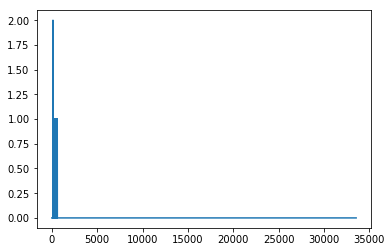

In [38]:
fig = plt.figure()
plt.plot(tof[:,1443])
plt.show()

In [16]:
tof_sipm_sort = np.argsort(tof[:,0])

In [17]:
tof_sipm_sort = tof[tof_sipm_sort,:]

In [18]:
tof_sipm_sort

array([[1034, 5384],
       [1034, 2426],
       [1035,  839],
       ..., 
       [4474, 1643],
       [4474,  909],
       [4479,  706]])